# 1. 데이터 탐색 & EDA

**Objective : 월별 고객 프로필 바탕으로 고객이 향후 신용카드 잔액을 갚지 않을 확률을 예측하는 것,  
to predict, for each customer_ID, the probability of a future payment default (target = 1)**  
목표이진변수는 최근 신용카드 명세서 이후 18개월 실적창구를 관찰해 산출하며,  
**고객이 최근 명세서 날짜 이후 120일 이내에 납부해야 할 금액을 납부하지 않으면 디폴트(채무 불이행)로 간주**한다 

  
데이터 세트에는 각 명세서 날짜에 각 고객에 대해 집계된 정보들이 포함, 익명화 및 정규화되어 있음 

D_* = Delinquency variables 연체  
S_* = Spend variables  소비   
P_* = Payment variables  지불  
B_* = Balance variables  잔고  
R_* = Risk variables  위험   
  
*(??) 음수 클래스는 이 데이터 세트에 대해 5%로 하위 샘플링되었으므로 점수 메트릭에서 20배 가중치를 받는다 (??)*

### References

https://www.kaggle.com/code/datark1/american-express-eda  
https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import matplotlib.pylab as plt
import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
warnings.filterwarnings('ignore')

## 데이터셋 읽기

*문제: 데이터가 대용량임  
sol)   
1.Read data chunk by chunk  https://lsjsj92.tistory.com/591, https://wikidocs.net/135935   
2.Use a compressed dataset  

### 1. Read data chunk by chunk

In [4]:
train_data_path = "C:/Users/kimch/Desktop/American Express/train_data.csv"
# 주소 input/... 뭐시기는 어떻게 하는것인지...?
chunksize = 13000
train = pd.read_csv(train_data_path, chunksize=chunksize)

In [5]:
# 돌릴 때 마다 새 13000개씩 끊겨진 데이터를 얻을 수 있음
# 근데 그러면 모든 데이터에 대한 분석 어케 함...??
t = train.__next__()
t.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.001034,0.004838,NaN,0.

### 2. Use a compressed dataset

In [6]:
train_r = pd.read_parquet("C:/Users/kimch/Desktop/American Express/train.parquet")

In [7]:
labels = pd.read_csv("C:/Users/kimch/Desktop/American Express/train_labels.csv")

In [8]:
train_r = train_r.merge(labels, right_on = "customer_ID", left_on = "customer_ID")

In [9]:
train_r.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,NaN,NaN,0,6,0.708906,0.170600,0,0.358587,0.525351,0.255736,-1,0.063902,0.059416,0.0,0.148698,4,0.008207,0,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0,1.0,0,0.161345,0.148266,2896,0.354596,0.152025,0.118075,0,0.158612,0.065728,0.018385,8,0.199617,0.308233,0.016361,15,0.091071,0,0,0,0,NaN,0.652984,0,-1,0,6,0.272008,0.008363,524,0.002644,0.009013,0,0,0.119403,0,4,0.050882,NaN,0.0,1,1,NaN,0.004327,0.0,NaN,0.007729,0.000272,0,0,0,-1,0.002271,0,0,0,0.002310,0,1,0.008033,1.0,0.084683,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.002537,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1,1.004587,0.893734,-1,2,0.009968,0.004572,-1,1.008949,2,-1,0,NaN,-1,NaN,1.0,0.210060,0.676922,0,1,0.238250,0,5,0.232120,0.236266,0,0.702280,3,0,16,0,2,1,1.007819,1,0,NaN,0.0,0.0,NaN,0.004345,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,NaN,NaN,0,5,0.712795,0.113239,0,0.353630,0.521311,0.223329,-1,0.065261,0.057744,0.0,0.149723,4,0.008373,0,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0,1.0,0,0.140951,0.143530,2896,0.326757,0.156201,0.118737,0,0.148459,0.093935,0.013035,8,0.151387,0.265026,0.017688,15,0.086805,0,0,0,0,NaN,0.647093,0,-1,0,6,0.188970,0.004030,524,0.004193,0.007842,0,0,0.140611,0,4,0.040469,NaN,0.0,1,1,NaN,0.004203,0.0,NaN,0.001864,0.000979,0,0,0,-1,0.009810,0,0,0,0.001327,0,1,0.000760,1.0,0.081843,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.008427,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.786007,1,1.004118,0.906841,-1,2,0.003921,0.004654,-1,1.003205,2,-1,0,NaN,-1,NaN,1.0,0.184093,0.822281,0,1,0.247217,0,5,0.243532,0.241885,0,0.707017,3,0,16,0,2,1,1.004333,1,0,NaN,0.0,0.0,NaN,0.007495,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,NaN,NaN,0,5,0.720884,0.060492,0,0.334650,0.524568,0.189424,-1,0.066982,0.056647,0.0,0.151955,4,0.009355,0,0.206629,0.738044,0.134073,NaN,0.048367,0.010077,0,1.0,0,0.112229,0.137014,3166,0.304124,0.153795,0.114534,0,0.139504,0.084757,0.056653,8,0.305883,0.212165,0.063955,15,0.094001,0,0,0,0,NaN,0.645819,0,-1,0,6,0.495308,0.006838,702,0.001337,0.006025,0,0,0.075868,0,4,0.047454,NaN,0.0,1,1,NaN,0.001782,0.0,NaN,0.005419,0.006149,0,0,0,-1,0.009362,0,0,0,0.007624,0,1,0.004056,1.0,0.081954,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.007327,0,0,0,0,0,1,0,0,0,3,1,0,0,0,0,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.806840,1,1.009285,0.928719,-1,2,0.001264,0.019176,-1,1.000754,2,-1,0,NaN,-1,NaN,1.0,0.154837,0.853498,0,1,0.239867,0,5,0.240768,0.239710,0,0.704843,3,0,16,0,2,1,1.007831,1,0,NaN,0.0,0.0,NaN,0.009227,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.

In [10]:
train_r.shape

(5531451, 191)

## 데이터 확인

In [24]:
t.dtypes

customer_ID     object
S_2             object
P_2            float64
D_39           float64
B_1            float64
B_2            float64
R_1            float64
S_3            float64
D_41           float64
B_3            float64
D_42           float64
D_43           float64
D_44           float64
B_4            float64
D_45           float64
B_5            float64
R_2            float64
D_46           float64
D_47           float64
D_48           float64
D_49           float64
B_6            float64
B_7            float64
B_8            float64
D_50           float64
D_51           float64
B_9            float64
R_3            float64
D_52           float64
P_3            float64
B_10           float64
D_53           float64
S_5            float64
B_11           float64
S_6            float64
D_54           float64
R_4            float64
S_7            float64
B_12           float64
S_8            float64
D_55           float64
D_56           float64
B_13           float64
R_5        

**time stamp: S_2  
범주형 변수: B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126**

### time stamp

In [41]:
print("train set time stamp :", train_r["S_2"].min(),"~", train_r["S_2"].max())

train set time stamp : 2017-03-01 ~ 2018-03-31


### 범주형 변수

In [35]:
# categorical로 type 변경해주기 
categorical = ["B_30", "B_38", "D_63", "D_64", "D_66", "D_68", "D_114", "D_116", "D_117", "D_120", "D_126"]
train_r[categorical] = train_r[categorical].astype("category")

In [23]:
train_r["B_30"].value_counts().sort_index()

-1       2016
 0    4710663
 1     763955
 2      54817
Name: B_30, dtype: int64

In [24]:
train_r["B_38"].value_counts().sort_index()

-1       2016
 1    1160047
 2    1953232
 3    1255315
 4     294917
 5     444856
 6     162040
 7     259028
Name: B_38, dtype: int64

In [25]:
train_r["D_63"].value_counts().sort_index()

0     930133
1      25786
2      10556
3    4119621
4     438390
5       6965
Name: D_63, dtype: int64

In [26]:
train_r["D_64"].value_counts().sort_index()

-1     217442
 0    2913244
 1      37205
 2     840112
 3    1523448
Name: D_64, dtype: int64

In [27]:
train_r["D_66"].value_counts().sort_index()

-1    4908097
 0       6288
 1     617066
Name: D_66, dtype: int64

In [28]:
train_r["D_68"].value_counts().sort_index()

-1     216503
 0      15925
 1     133122
 2     220111
 3     484442
 4     477187
 5    1201706
 6    2782455
Name: D_68, dtype: int64

In [29]:
train_r["D_114"].value_counts().sort_index()

-1     176716
 0    2038257
 1    3316478
Name: D_114, dtype: int64

In [30]:
train_r["D_116"].value_counts().sort_index()

-1     176716
 0    5348109
 1       6626
Name: D_116, dtype: int64

In [31]:
train_r["D_117"].value_counts().sort_index()

-1     176716
 0    1456084
 2     122967
 3     666808
 4    1166400
 5    1138666
 6     459290
 7     344520
Name: D_117, dtype: int64

In [32]:
train_r["D_120"].value_counts().sort_index()

-1     176716
 0    4729723
 1     625012
Name: D_120, dtype: int64

In [33]:
train_r["D_126"].value_counts().sort_index()

-1     116816
 0     260898
 1     891323
 2    4262414
Name: D_126, dtype: int64

## 결측치

### 1. 확인

In [43]:
train_r.isnull().sum().sort_values(ascending=False)

D_88           5525447
D_110          5500117
B_39           5497819
D_73           5475595
B_42           5459973
D_134          5336752
B_29           5150035
D_132          4988874
D_76           4908954
D_42           4740137
D_142          4587043
D_53           4084585
D_50           3142402
B_17           3137598
D_105          3021431
D_56           2990943
S_9            2933643
D_77           2513912
D_43           1658396
S_27           1400935
D_46           1211699
S_3            1020544
S_7            1020544
D_62            758161
D_48            718725
D_61            598052
P_3             301492
D_69            194473
D_55            184803
D_115           176716
D_121           176716
D_119           176716
D_118           176716
R_27            128703
D_141           101548
D_128           101548
D_131           101548
D_130           101548
D_104           101548
B_13             49519
P_2              45985
D_133            42716
D_144            40727
D_102      

In [62]:
missing_percentage = pd.DataFrame(columns=['column', 'null_percentage'])

for col in train_r.columns:
    p = round((train_r[col].isnull().sum() / train_r[col].shape[0]), 2)
    missing_percentage =  missing_percentage.append(pd.DataFrame([[col, p]], columns=['column', 'percentage']), ignore_index=True)

missing_percentage.set_index("column", inplace=True)
missing_percentage.sort_values(by="percentage", ascending=False)

,percentage
column,
D_88,1.00
B_42,0.99
D_110,0.99
D_73,0.99
B_39,0.99
D_134,0.96
B_29,0.93
D_132,0.90
D_76,0.89


### 2. 처리

결측치 비율이 매우 높은 열은 드롭시키고 분석을 진행해도 되지 않나 싶다. (D_53: 0.74 ~ D_88: 1.00)  
그 외에 결측치들이 있는 열들은 군집분석을 실행한 후 비슷한 군집의 평균이나 중간값으로 대체하고 분석을 진행하면 될 것 같다.

## 시각화

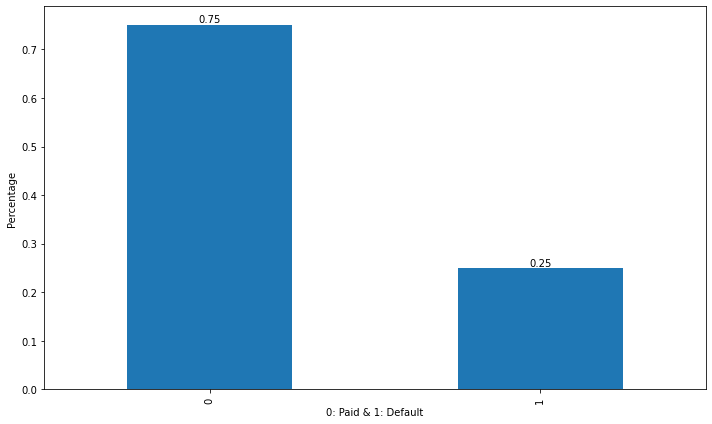

In [75]:
target = train_r["target"].value_counts()/len(train_r)

ax = target.plot(kind="bar", figsize=[10,6])

ax.bar_label(ax.containers[0], fmt="%.2f")
ax.set_xlabel("0: Paid & 1: Default")
ax.set_ylabel("Percentage")

plt.tight_layout()
plt.show()

## 범주형 변수

In [103]:
categorical = ["B_30", "B_38", "D_63", "D_64", "D_66", "D_68", "D_114", "D_116", "D_117", "D_120", "D_126"]

for c in categorical:
    selected = train_r[[c, "target"]]
    grouped = pd.pivot_table(selected, index="target", columns=c, values="target", aggfunc=len)
    print(grouped)
    print()

B_30      -1        0       1      2
target                              
0       1298  3846720  284346  21218
1        718   863943  479609  33599

B_38      -1        1        2       3       4       5      6       7
target                                                               
0       1298  1003134  1829580  842814   88559  195990  62399  129808
1        718   156913   123652  412501  206358  248866  99641  129220

D_63         0      1     2        3       4     5
target                                            
0       772136  20863  8050  3036914  310865  4754
1       157997   4923  2506  1082707  127525  2211

D_64        -1        0      1       2        3
target                                         
0       128586  2420164  28993  575273  1000566
1        88856   493080   8212  264839   522882

D_66         -1     0       1
target                       
0       3645875  3875  503832
1       1262222  2413  113234

D_68        -1      0      1       2       3       

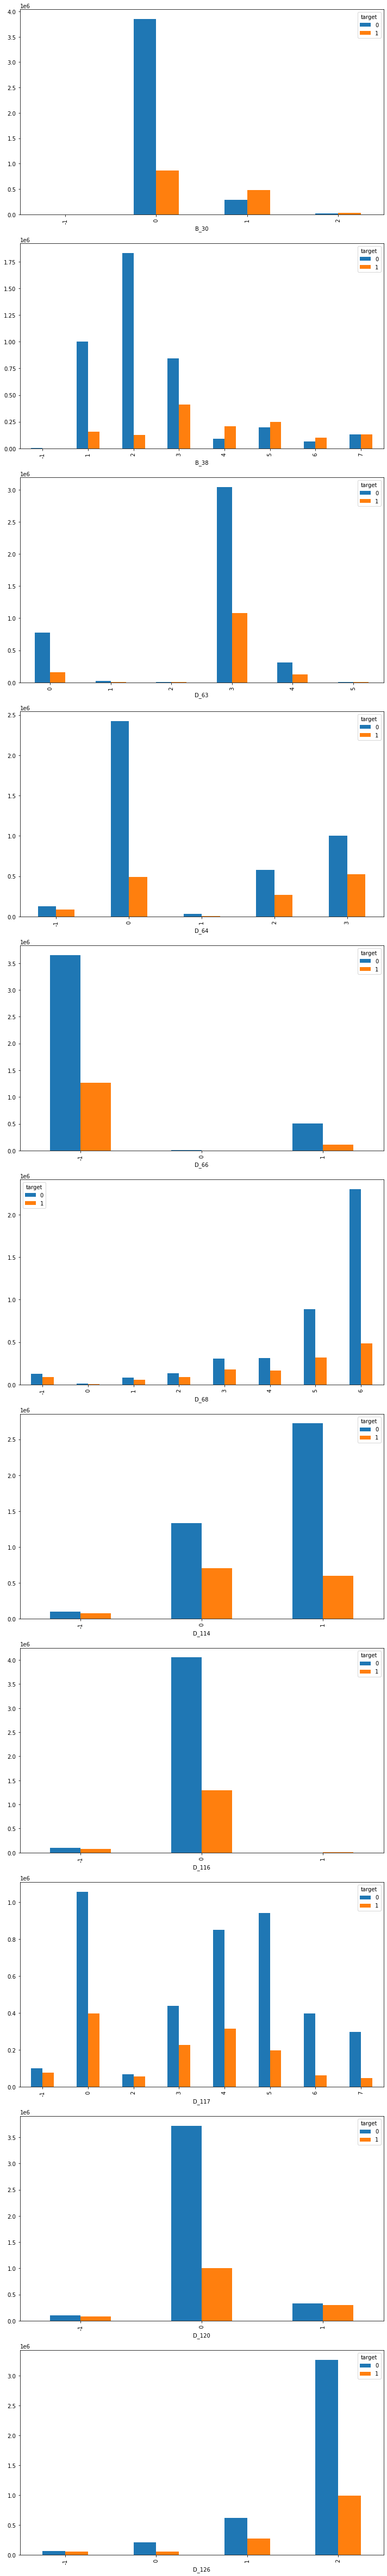

In [126]:
fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(10,66))
for i in range(11):
        selected = train_r[[categorical[i], "target"]]
        grouped = pd.pivot_table(selected, index="target", columns = categorical[i], values="target", aggfunc=len)
        t = grouped.transpose()
        ax = t.plot(kind="bar", ax= axes[i])
        
plt.tight_layout()
plt.show()

## 수치형 변수

In [12]:
train_num = train_r.drop(columns= ["B_30", "B_38", "D_63", "D_64", "D_66", "D_68", "D_114", "D_116", "D_117", "D_120", "D_126"])

## Deliquency

In [134]:
deliquency = train_num.filter(regex='D_')
deliquency = pd.concat([train_num[['S_2']], deliquency, train_num[["target"]]], axis=1)
deliquency.head()

,S_2,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,D_49,D_50,D_51,D_52,D_53,D_54,D_55,D_56,D_58,D_59,D_60,D_61,D_62,D_65,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_78,D_79,D_80,D_81,D_82,D_83,D_84,D_86,D_87,D_88,D_89,D_91,D_92,D_93,D_94,D_96,D_102,D_103,D_104,D_105,D_106,D_107,D_108,D_109,D_110,D_111,D_112,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,D_130,D_131,D_132,D_133,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,2017-03-09,0,0.0,NaN,NaN,0,0.708906,0.358587,0.525351,0.255736,-1,0.148698,4,0.207334,NaN,1.0,0.354596,0.152025,0.158612,8,0.199617,0.308233,0.091071,0,0.009013,0,0.119403,0,NaN,1,1,NaN,NaN,0,0,0,0,1,0,0,0,-1,NaN,0,3,1,0,0,0,0.766688,1,1.004587,0.893734,-1,2,-1,0,NaN,-1,1.0,0,0.238250,0.232120,0.236266,0.702280,3,0,16,0,1,1.007819,1,0.0,0.0,NaN,0.004345,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0,0
1,2017-04-07,0,0.0,NaN,NaN,0,0.712795,0.353630,0.521311,0.223329,-1,0.149723,4,0.202778,NaN,1.0,0.326757,0.156201,0.148459,8,0.151387,0.265026,0.086805,0,0.007842,0,0.140611,0,NaN,1,1,NaN,NaN,0,0,0,0,1,0,0,0,-1,NaN,0,3,1,0,0,0,0.786007,1,1.004118,0.906841,-1,2,-1,0,NaN,-1,1.0,0,0.247217,0.243532,0.241885,0.707017,3,0,16,0,1,1.004333,1,0.0,0.0,NaN,0.007495,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0,0
2,2017-05-28,3,0.0,NaN,NaN,0,0.720884,0.334650,0.524568,0.189424,-1,0.151955,4,0.206629,NaN,1.0,0.304124,0.153795,0.139504,8,0.305883,0.212165,0.094001,0,0.006025,0,0.075868,0,NaN,1,1,NaN,NaN,0,0,0,0,1,0,0,0,-1,NaN,0,3,1,0,0,0,0.806840,1,1.009285,0.928719,-1,2,-1,0,NaN,-1,1.0,0,0.239867,0.240768,0.239710,0.704843,3,0,16,0,1,1.007831,1,0.0,0.0,NaN,0.009227,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0,0
3,2017-06-13,0,0.0,NaN,NaN,0,0.723997,0.323271,0.530929,0.135586,-1,0.151219,4,0.208214,NaN,1.0,0.275055,0.155772,0.138100,8,0.273553,0.204300,0.094854,0,0.005271,0,0.150209,0,NaN,1,1,NaN,NaN,0,0,0,0,1,0,0,0,-1,NaN,0,3,1,0,0,0,0.808214,1,1.004514,0.935383,-1,2,-1,0,NaN,-1,1.0,0,0.240910,0.239400,0.240727,0.711546,3,0,16,0,1,1.003460,1,0.0,0.0,NaN,0.007206,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0,0
4,2017-07-16,0,0.0,NaN,NaN,0,0.720619,0.231009,0.529305,NaN,-1,0.154026,4,0.205468,NaN,1.0,0.231110,0.154914,0.126443,8,0.233103,0.175655,0.093915,0,0.000152,0,0.096441,0,NaN,1,1,NaN,NaN,0,0,0,0,1,0,0,0,-1,NaN,0,3,1,0,0,0,0.822281,1,1.005735,0.953363,-1,2,-1,0,NaN,-1,1.0,0,0.247939,0.244199,0.242325,0.705343,3,0,16,0,1,1.005053,1,0.0,0.0,NaN,0.006312,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0,0


In [144]:
deliquency.shape

(5531451, 89)

In [138]:
deliquency.columns[1:88]

Index(['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48',
       'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58',
       'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72',
       'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81',
       'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92',
       'D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106',
       'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_115',
       'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127',
       'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135',
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object')

In [141]:
d = [['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48'],
     ['D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58'],
     ['D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72'],
     ['D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81'],
     ['D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92'],
     ['D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106','D_107'],
     ['D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119'],
     ['D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127','D_128', 'D_129', 'D_130'],
     ['D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139'],
     ['D_140', 'D_141', 'D_142', 'D_143','D_144', 'D_145']]

IndexError: list index out of range

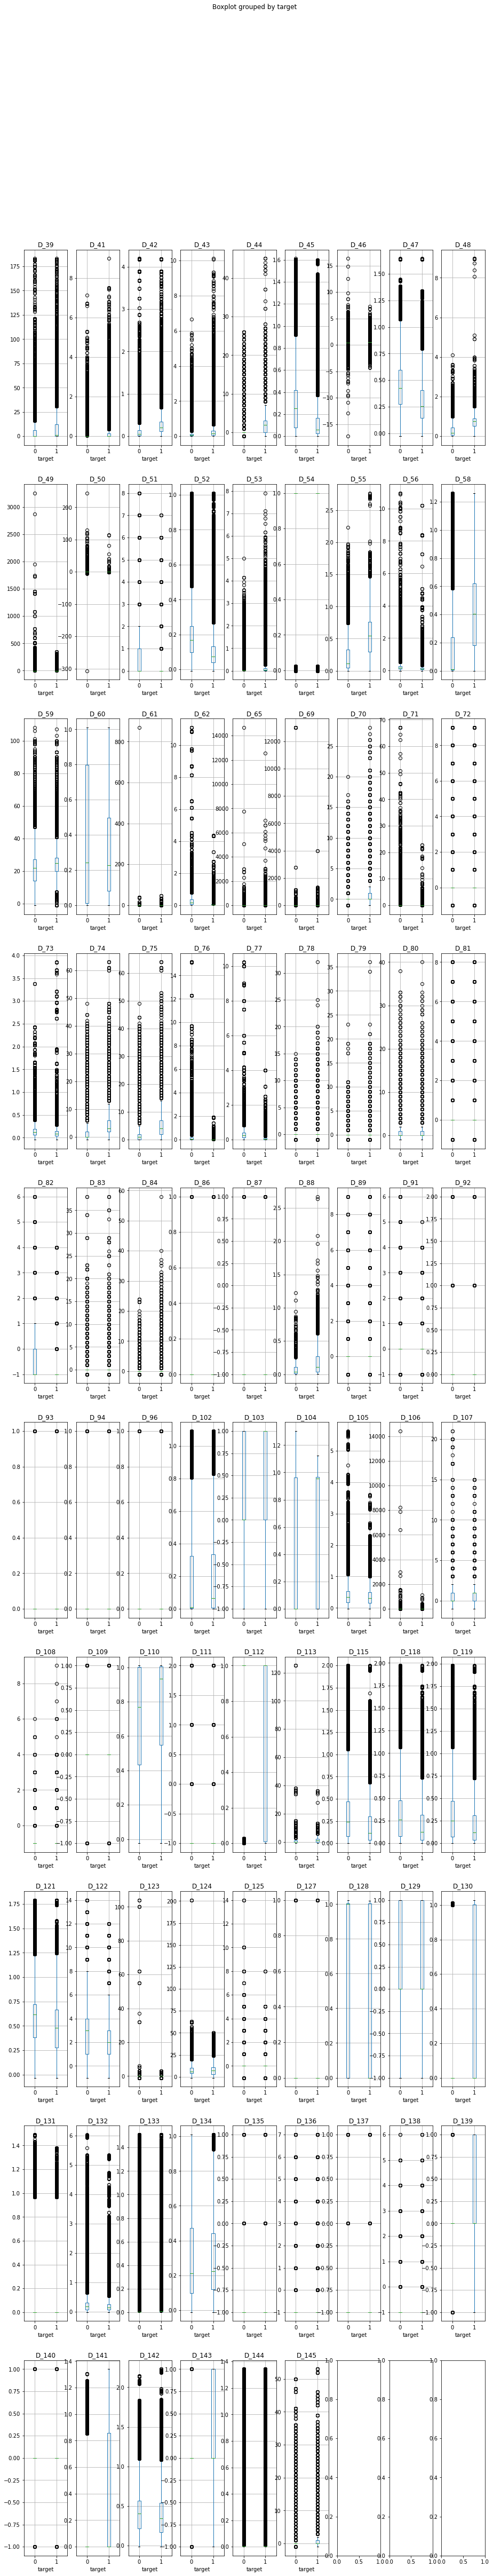

In [142]:
fig, axes = plt.subplots(nrows=10, ncols=9, figsize=(15,80))

for i in range(10):
    for j in range(9):
        deliquency.boxplot(column=d[i][j], by="target", ax=axes[i][j])
        
for ax in axes:
    ax.set_xlabel("Target")
    
plt.suptitle('')
plt.tight_layout()

plt.show()

In [145]:
d = deliquency.drop(columns=["S_2"])

In [146]:
d_corr = d.corr()
sns.heatmap(d_corr, xticklabels=d_corr.columns, yticklabels=d_corr.columns, cmap="Blues")

MemoryError: Unable to allocate 3.63 GiB for an array with shape (88, 5531451) and data type float64

## Spend

In [14]:
spend = train_num.filter(regex="S_")
spend = pd.concat([spend, train_num[["target"]]], axis=1)
spend.head()

,S_2,S_3,S_5,S_6,S_7,S_8,S_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,target
0,2017-03-09,0.124035,0.023381,0,0.161345,2896,0.065728,15,0.272008,524,4,0.002271,0.008033,0,0.002537,0,0.894090,0.135561,0.911191,0.974539,0.001243,0.676922,0
1,2017-04-07,0.126750,0.030599,0,0.140951,2896,0.093935,15,0.188970,524,4,0.009810,0.000760,0,0.008427,0,0.902135,0.136333,0.919876,0.975625,0.004561,0.822281,0
2,2017-05-28,0.123977,0.048367,0,0.112229,3166,0.084757,15,0.495308,702,4,0.009362,0.004056,0,0.007327,0,0.939654,0.134938,0.958699,0.974067,0.011736,0.853498,0
3,2017-06-13,0.117169,0.030063,0,0.102838,2218,0.048382,15,0.508670,524,5,0.004876,0.006969,0,0.007053,0,0.913205,0.140058,0.926341,0.975499,0.007571,0.844667,0
4,2017-07-16,0.117325,0.054221,0,0.094311,2896,0.039259,17,0.216507,524,4,0.007447,0.001770,0,0.007728,0,0.921026,0.131620,0.933479,0.978027,0.018200,0.811199,0


In [15]:
spend.shape

(5531451, 23)

In [16]:
spend.columns

Index(['S_2', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13',
       'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24',
       'S_25', 'S_26', 'S_27', 'target'],
      dtype='object')

In [17]:
s = [['S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12'], 
     ['S_13','S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22'], 
     ['S_23', 'S_24','S_25', 'S_26', 'S_27']]

IndexError: list index out of range

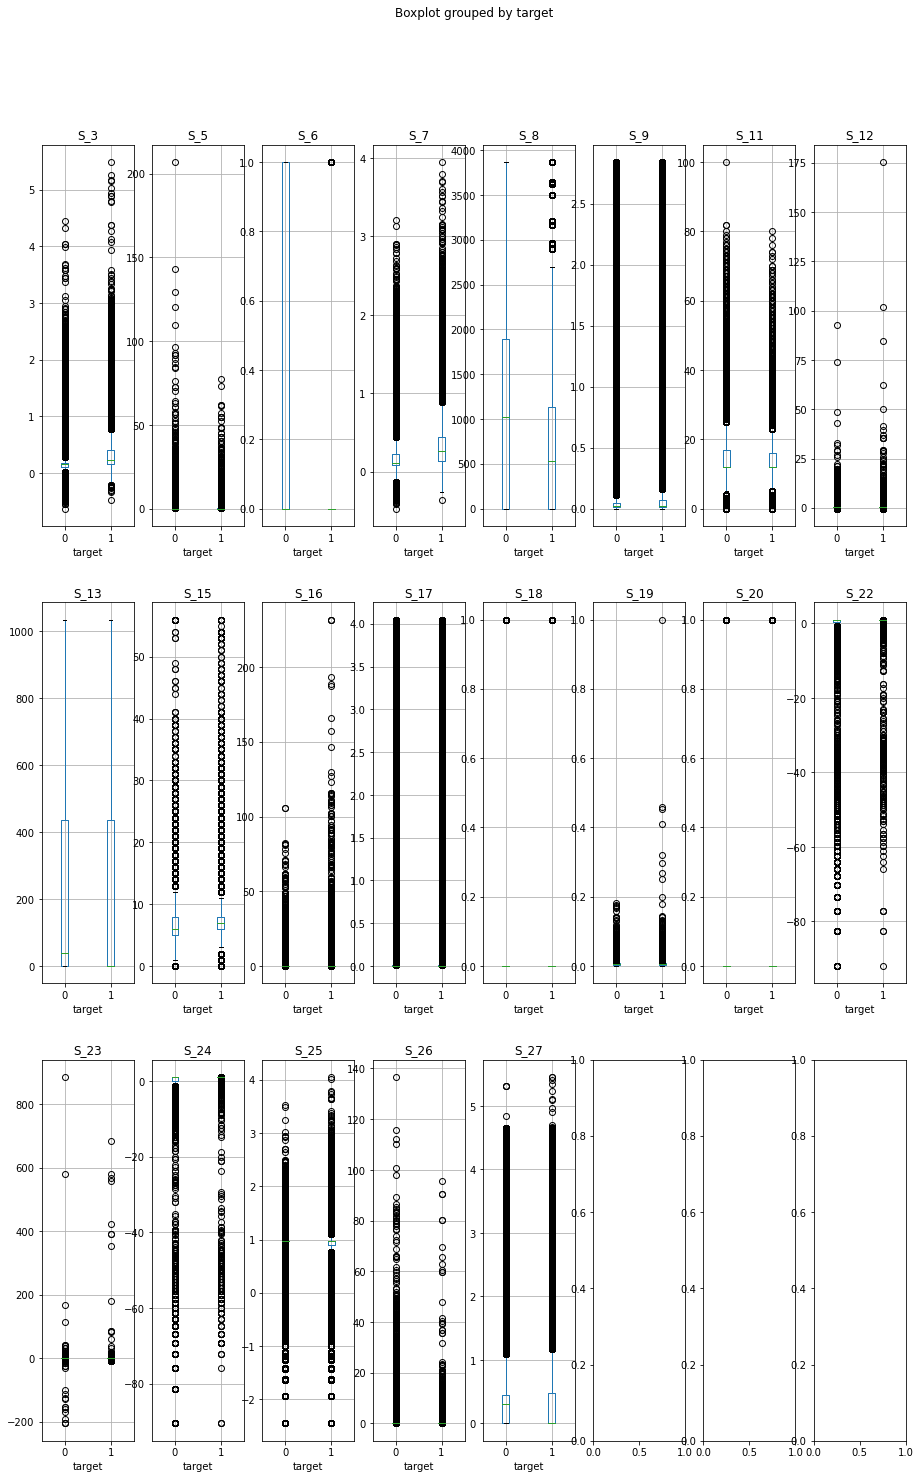

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(15,24))

for i in range(3):
    for j in range(8):
        spend.boxplot(column=s[i][j], by="target", ax = axes[i][j])
        
for ax in axes:
    ax.set_xlabel("Target")

plt.title("")
plt.suptitle('')
plt.tight_layout()

plt.show()

In [20]:
s = spend.drop(columns=["S_2"])

<AxesSubplot:>

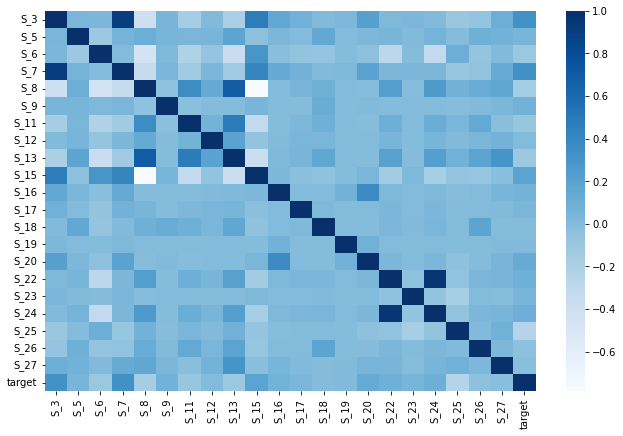

In [23]:
s_corr = s.corr()

fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(s_corr, xticklabels=s_corr.columns, yticklabels=s_corr.columns, cmap="Blues", ax=ax)

S_3과 S_7, S_22와 S_24가 유의미하게 상관관계가 높은것을 볼 수 있다. 

## Payment

In [148]:
payment = train_num.filter(regex='P_')
payment = pd.concat([train_num[['S_2']], payment, train_num[["target"]]], axis=1)
payment.head()

,S_2,P_2,P_3,P_4,target
0,2017-03-09,0.938469,0.736463,0.0,0
1,2017-04-07,0.936665,0.720886,0.0,0
2,2017-05-28,0.954180,0.738044,0.0,0
3,2017-06-13,0.960384,0.741813,0.0,0
4,2017-07-16,0.947248,0.691986,0.0,0


In [149]:
payment.shape

(5531451, 5)

In [154]:
p = ["P_2", "P_3", "P_4"]

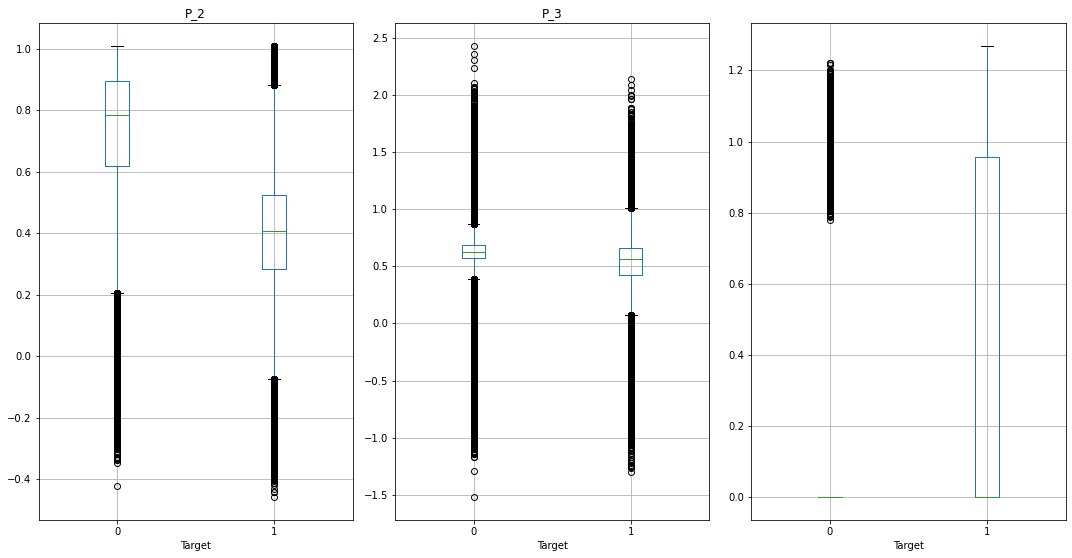

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,8))

for i in range(3):
        payment.boxplot(column=p[i], by="target", ax=axes[i])
        
for ax in axes:
    ax.set_xlabel("Target")
    
plt.title('')
plt.suptitle('')
plt.tight_layout()

plt.show()

In [156]:
p = payment.drop(columns=["S_2"])

<AxesSubplot:>

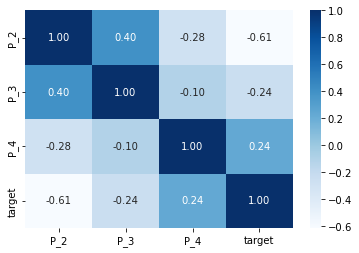

In [162]:
p_corr = p.corr()
sns.heatmap(p_corr, annot=True, fmt=".2f", xticklabels=p_corr.columns, yticklabels=p_corr.columns, cmap="Blues")

## Balance

In [24]:
balance = train_num.filter(regex='B_')
balance = pd.concat([train_num[['S_2']], balance, train_num[["target"]]], axis=1)
balance.head()

,S_2,B_1,B_2,B_3,B_4,B_5,B_6,B_7,B_8,B_9,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,B_19,B_20,B_21,B_22,B_23,B_24,B_25,B_26,B_27,B_28,B_29,B_31,B_32,B_33,B_36,B_37,B_39,B_40,B_41,B_42,target
0,2017-03-09,0.008724,1.006838,0.004709,6,0.170600,0.063902,0.059416,0.0,0.008207,0.096219,0.002768,0.148266,0.118075,0.018385,0.016361,0,NaN,0.652984,0,0,0.002644,0,0.050882,0.004327,0.007729,0.000272,0.002310,0.084683,NaN,1,0,1,0.009968,0.004572,NaN,0.210060,0,NaN,0
1,2017-04-07,0.004923,1.000653,0.002714,5,0.113239,0.065261,0.057744,0.0,0.008373,0.099804,0.002749,0.143530,0.118737,0.013035,0.017688,0,NaN,0.647093,0,0,0.004193,0,0.040469,0.004203,0.001864,0.000979,0.001327,0.081843,NaN,1,0,1,0.003921,0.004654,NaN,0.184093,0,NaN,0
2,2017-05-28,0.021655,1.009672,0.009423,5,0.060492,0.066982,0.056647,0.0,0.009355,0.134073,0.010077,0.137014,0.114534,0.056653,0.063955,0,NaN,0.645819,0,0,0.001337,0,0.047454,0.001782,0.005419,0.006149,0.007624,0.081954,NaN,1,0,1,0.001264,0.019176,NaN,0.154837,0,NaN,0
3,2017-06-13,0.013683,1.002700,0.005531,4,0.166782,0.083720,0.049253,0.0,0.006782,0.134437,0.009667,0.129017,0.120740,0.012498,0.022732,0,NaN,0.654358,0,0,0.008716,0,0.031705,0.005595,0.000646,0.009193,0.000034,0.060634,NaN,1,0,1,0.002729,0.011720,NaN,0.153939,0,NaN,0
4,2017-07-16,0.015193,1.000727,0.009312,3,0.143630,0.075900,0.048918,0.0,0.000519,0.121518,0.009484,0.129539,0.095178,0.027897,0.031171,0,NaN,0.650112,0,0,0.006821,0,0.032733,0.004933,0.001833,0.005738,0.002109,0.062492,NaN,1,0,1,0.009998,0.017598,NaN,0.120717,0,NaN,0


In [25]:
balance.shape

(5531451, 40)

In [26]:
balance.columns

Index(['S_2', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9',
       'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18',
       'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27',
       'B_28', 'B_29', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_39', 'B_40',
       'B_41', 'B_42', 'target'],
      dtype='object')

In [28]:
b = [['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8'], 
     ['B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16'], 
     ['B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24'],
     ['B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_31', 'B_32', 'B_33'], 
     ['B_36', 'B_37', 'B_39', 'B_40','B_41', 'B_42']]

IndexError: list index out of range

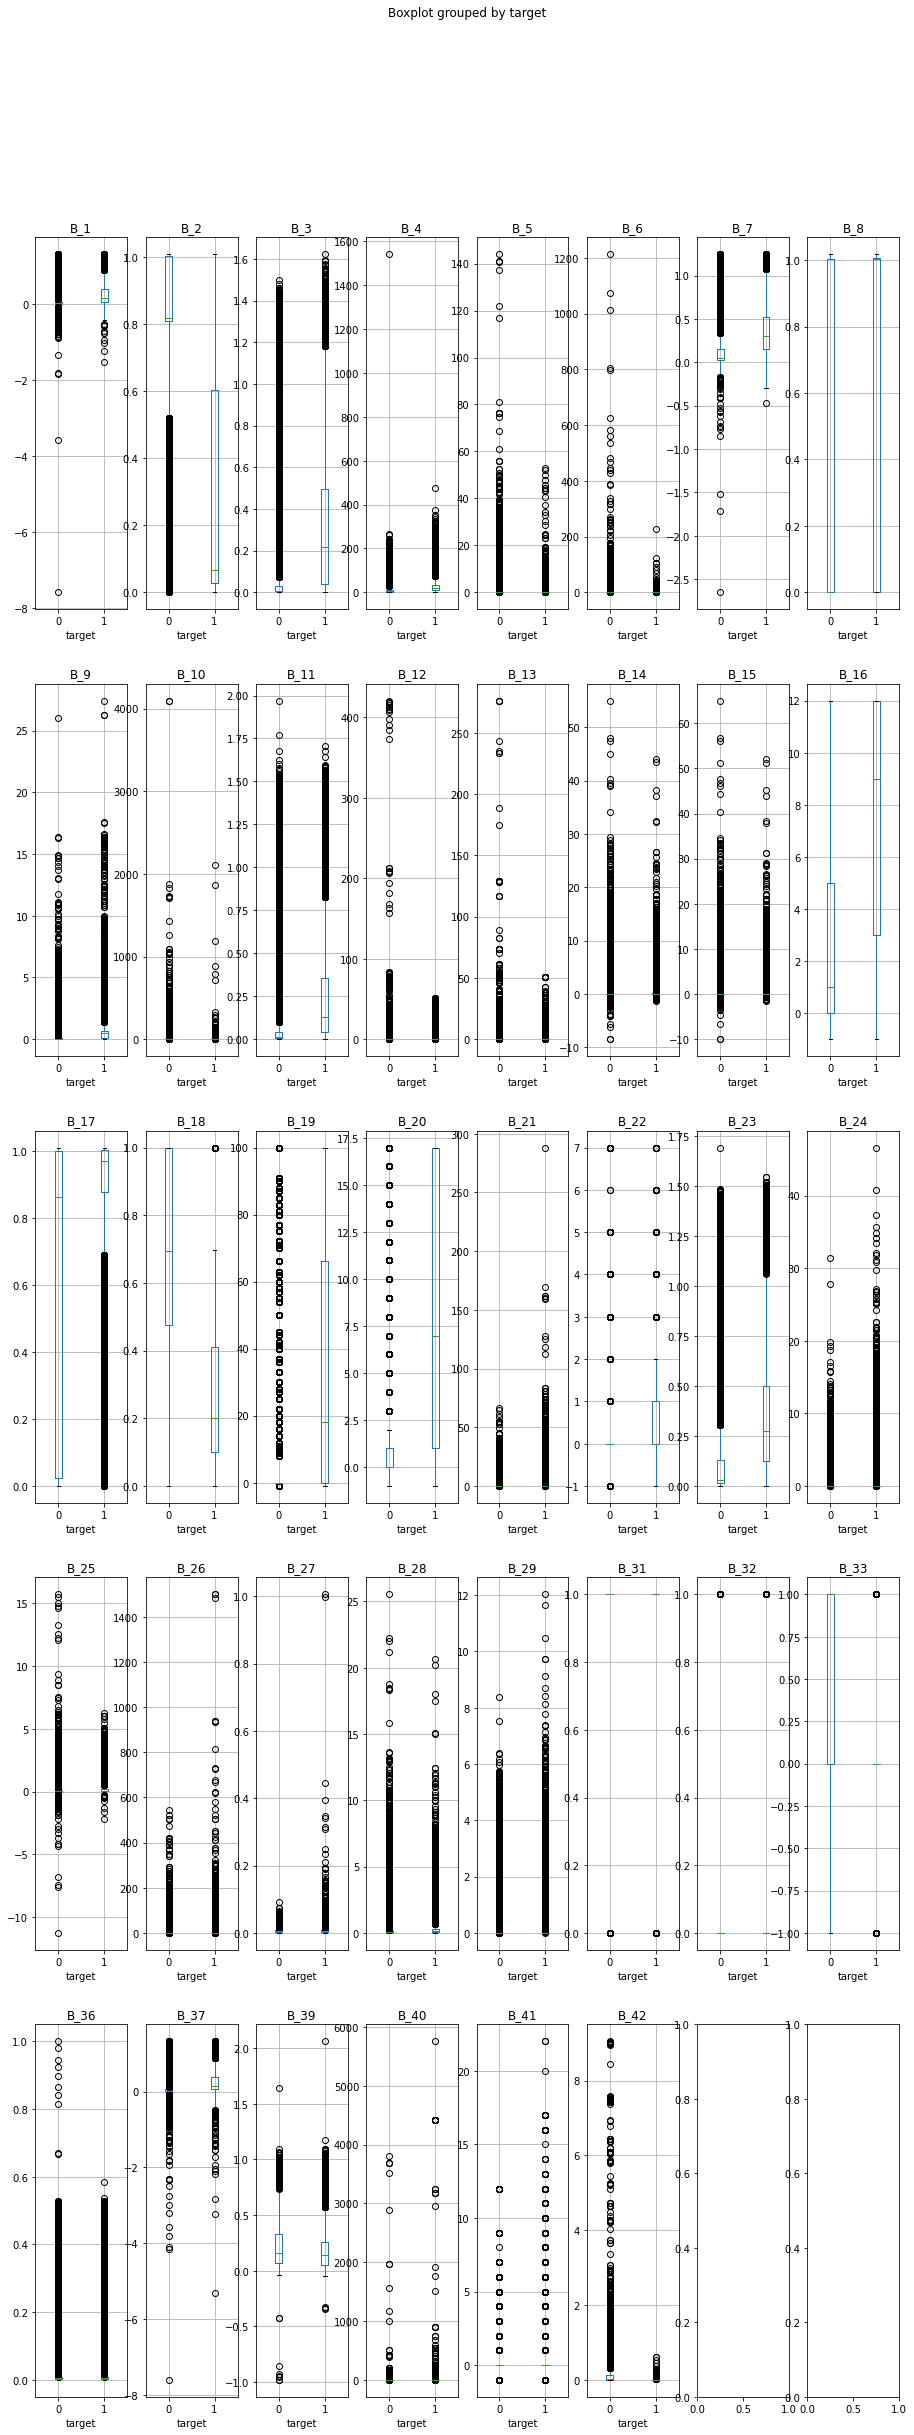

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(15,40))

for i in range(5):
    for j in range(8):
        balance.boxplot(column=b[i][j], by="target", ax = axes[i][j])
        
for ax in axes:
    ax.set_xlabel("Target")

plt.title("")
plt.suptitle('')
plt.tight_layout()

plt.show()

In [31]:
b = balance.drop(columns=["S_2"])

<AxesSubplot:>

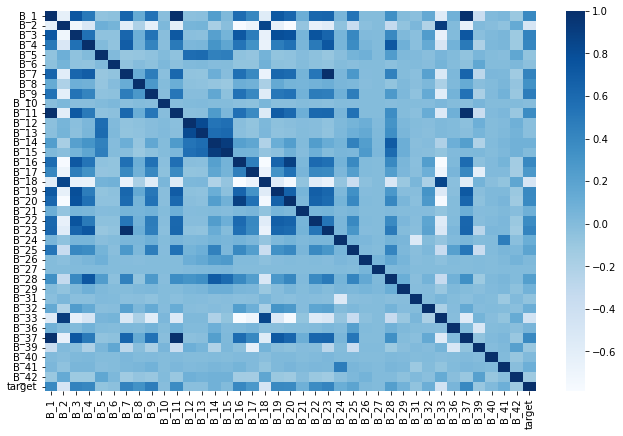

In [44]:
b_corr = b.corr()

fig, ax= plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(b_corr, xticklabels=b_corr.columns, yticklabels=b_corr.columns, cmap="Blues", ax=ax)

상관관계 높은 것:  
B_1 - B_3 / B_1 - B_11 / B_1 - B_37 /  B_2 - B_18 / B_2 - B_33 / B_7 - B_23 / B_18 - B_33

## Risk

In [34]:
risk = train_num.filter(regex="R_")
risk = pd.concat([train_num[["S_2"]], risk, train_num[["target"]]], axis=1)
risk.head()

,S_2,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,R_10,R_11,R_12,R_13,R_14,R_15,R_16,R_17,R_18,R_19,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,target
0,2017-03-09,0.009228,0,0,0,0,0.008363,0.0,0,-1,0,0,1.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,-1,1.008949,0,0
1,2017-04-07,0.006151,0,0,0,0,0.004030,0.0,0,-1,0,0,1.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,-1,1.003205,0,0
2,2017-05-28,0.006815,0,0,0,0,0.006838,0.0,0,-1,0,0,1.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,-1,1.000754,0,0
3,2017-06-13,0.001373,0,0,0,0,0.008183,0.0,0,-1,0,0,1.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,-1,1.005338,0,0
4,2017-07-16,0.007605,0,0,0,0,0.008605,0.0,0,-1,0,0,1.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,-1,1.003175,0,0


In [35]:
risk.shape

(5531451, 30)

In [36]:
risk.columns

Index(['S_2', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9',
       'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18',
       'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27',
       'R_28', 'target'],
      dtype='object')

In [43]:
r = [['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7'], 
     ['R_8', 'R_9','R_10', 'R_11', 'R_12', 'R_13', 'R_14'],
     ['R_15', 'R_16', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21'],
     ['R_22', 'R_23', 'R_24', 'R_25', 'R_26', 'R_27', 'R_28']]

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

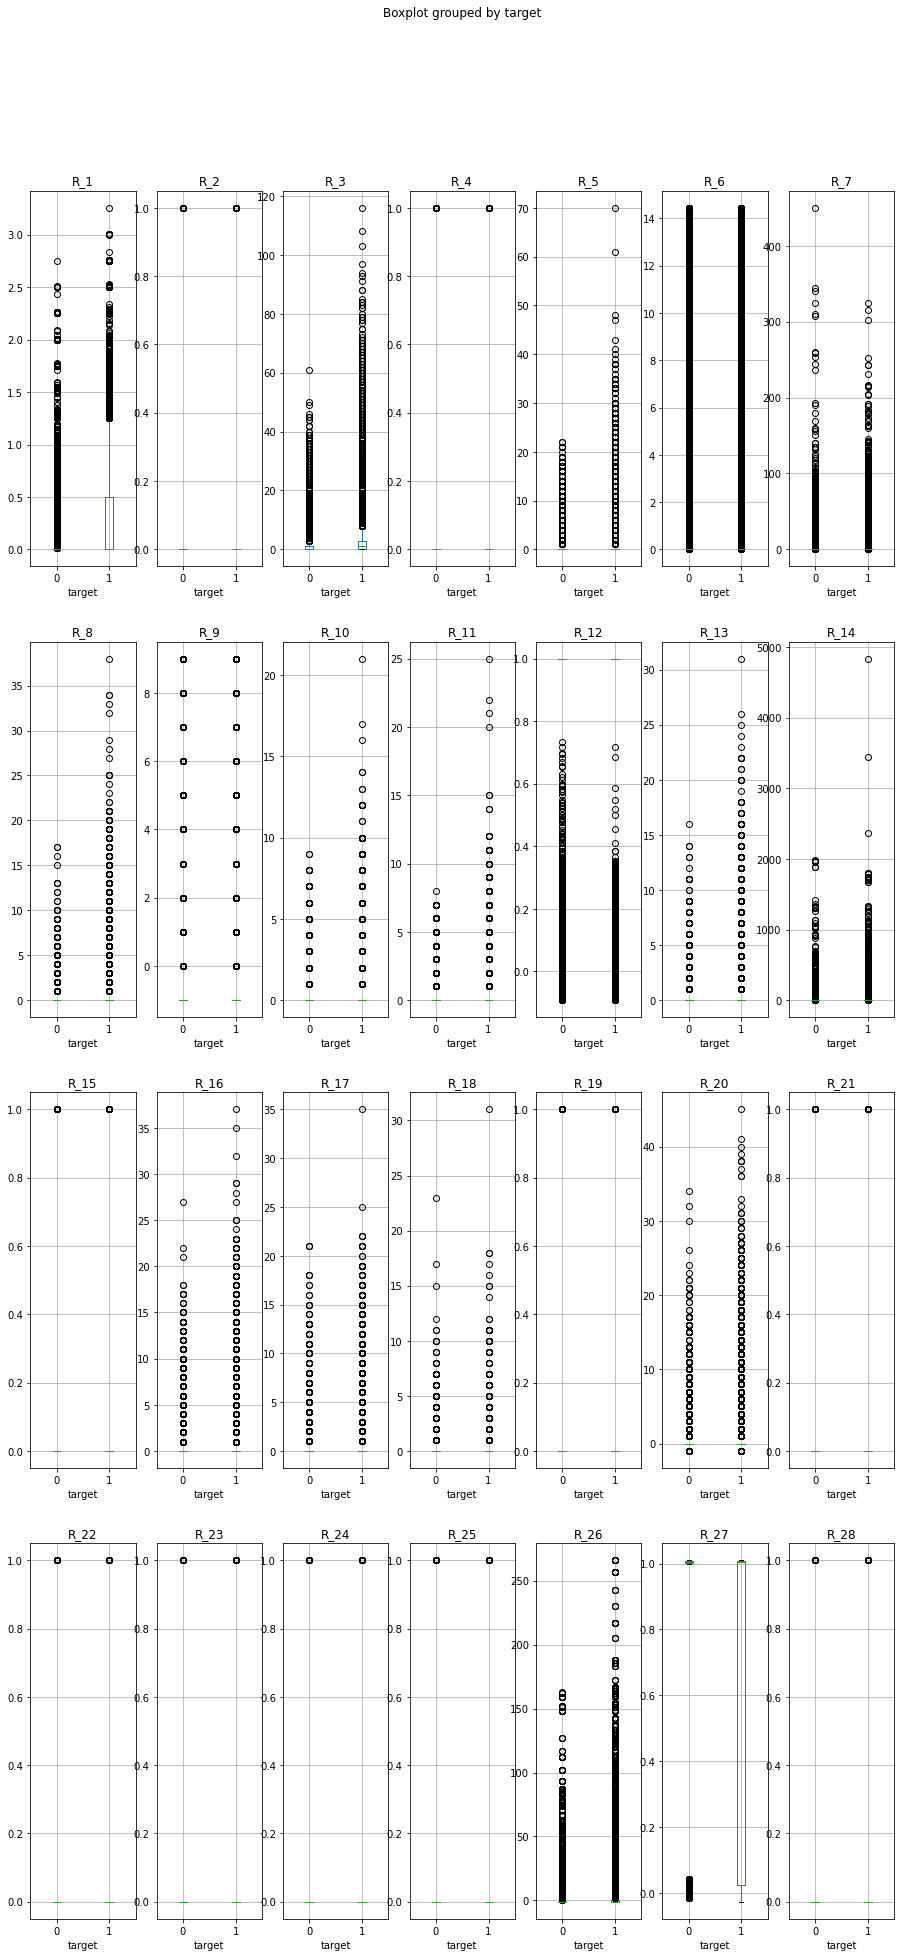

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(15,32))

for i in range(4):
    for j in range(7):
        risk.boxplot(column=r[i][j], by="target", ax = axes[i][j])
        
for ax in axes:
    ax.set_xlabel("Target")

plt.suptitle('')
plt.tight_layout()

plt.show()

In [39]:
r = risk.drop(columns=["S_2"])

<AxesSubplot:>

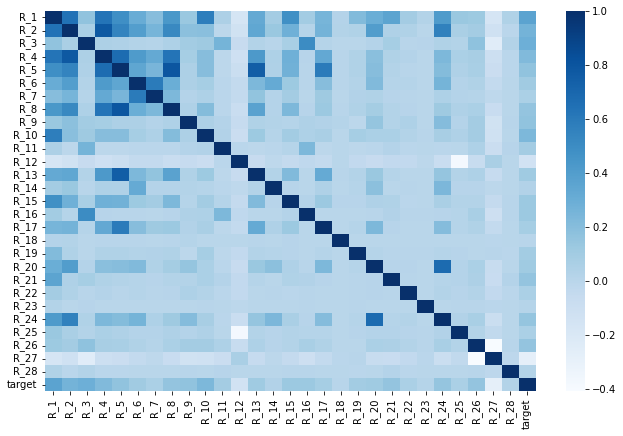

In [40]:
r_corr = r.corr()

fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(r_corr, xticklabels=r_corr.columns, yticklabels=r_corr.columns, cmap="Blues", ax=ax)